# 미션 9 개요

모델을 활용하여 FashionMNIST 데이터셋의 각 패션 아이템(예: 티셔츠, 바지, 스니커즈 등)을 조건부로 생성하는 작업을 수행한다.

각 클래스에 해당하는 이미지를 생성하는 cGAN (Conditional GAN) 모델을 직접 설계하고 학습

데이터
- torchvision.datasets.FashionMNIST로 다운로드
- 데이터 구성
    - 휸련 데이터 : 60,000장의 이미지
    - 테스트 데이터 : 10,000장의 이미지
    - 28 x 28 크기의 흑백 이미지 (10개 클래스)

- 클래스 목록:
    - T-shirt/top
    - Trouser
    - Pullover
    - Dress
    - Coat
    - Sandal
    - Shirt
    - Sneaker
    - Bag
    - Ankle boot

모델 성능 평가
- 조건부 레이블을 활용해 각 패션 아이템 클래스별로 이미지를 생성하는 모델을 구현
- 생성된 이미지의 품질을 정성적(시각적 평가) 및 정량적(FID, IS 등, optional)으로 평가

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

os.makedirs("pth", exist_ok=True)

PyTorch: 2.7.1
MPS available: True
mps


# 데이터 불러오기

In [4]:
# 데이터셋 및 DataLoader 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1] 범위로 정규화
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 이름 (FashionMNIST 클래스)
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
idx_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [5]:
image_size = 28      # MNIST 이미지 크기
num_classes = 10     # 10개 클래스 (0~9)
latent_dim = 100     # 잠재 공간 차원

# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 레이블 임베딩
        self.label_emb = nn.Embedding(num_classes, num_classes) #--> 10 * 10 like one-hot

        self.init_size = image_size // 4  # 7

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 → 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 14 → 28
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 레이블을 단일 채널 값으로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1 채널)와 레이블(1 채널)을 채널 차원에서 결합하여 2채널로 입력
            nn.Conv2d(1 + 1, 64, kernel_size=3, stride=2, padding=1),  # 28 → 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),      # 14 → 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),   # 128*7*7
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label = self.label_emb(labels)
        label = label.view(batch_size, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)
        # 이미지와 레이블을 채널 차원에서 연결
        d_in = torch.cat((img, label), 1)
        validity = self.model(d_in)
        return validity

Epoch [1/30]  D_loss: 0.8060  G_loss: 1.3759  D(x): 0.69  D(G(z)): 0.31
Epoch [2/30]  D_loss: 0.7942  G_loss: 1.4894  D(x): 0.70  D(G(z)): 0.29
Epoch [3/30]  D_loss: 0.9587  G_loss: 1.2894  D(x): 0.65  D(G(z)): 0.34
Epoch [4/30]  D_loss: 1.0519  G_loss: 1.1698  D(x): 0.62  D(G(z)): 0.37
Epoch [5/30]  D_loss: 1.0761  G_loss: 1.1400  D(x): 0.62  D(G(z)): 0.38
Epoch [6/30]  D_loss: 1.0663  G_loss: 1.1640  D(x): 0.62  D(G(z)): 0.38
Epoch [7/30]  D_loss: 1.0578  G_loss: 1.1807  D(x): 0.62  D(G(z)): 0.38
Epoch [8/30]  D_loss: 1.0498  G_loss: 1.2029  D(x): 0.63  D(G(z)): 0.37
Epoch [9/30]  D_loss: 1.0456  G_loss: 1.2178  D(x): 0.63  D(G(z)): 0.37
Epoch [10/30]  D_loss: 1.0337  G_loss: 1.2377  D(x): 0.63  D(G(z)): 0.37


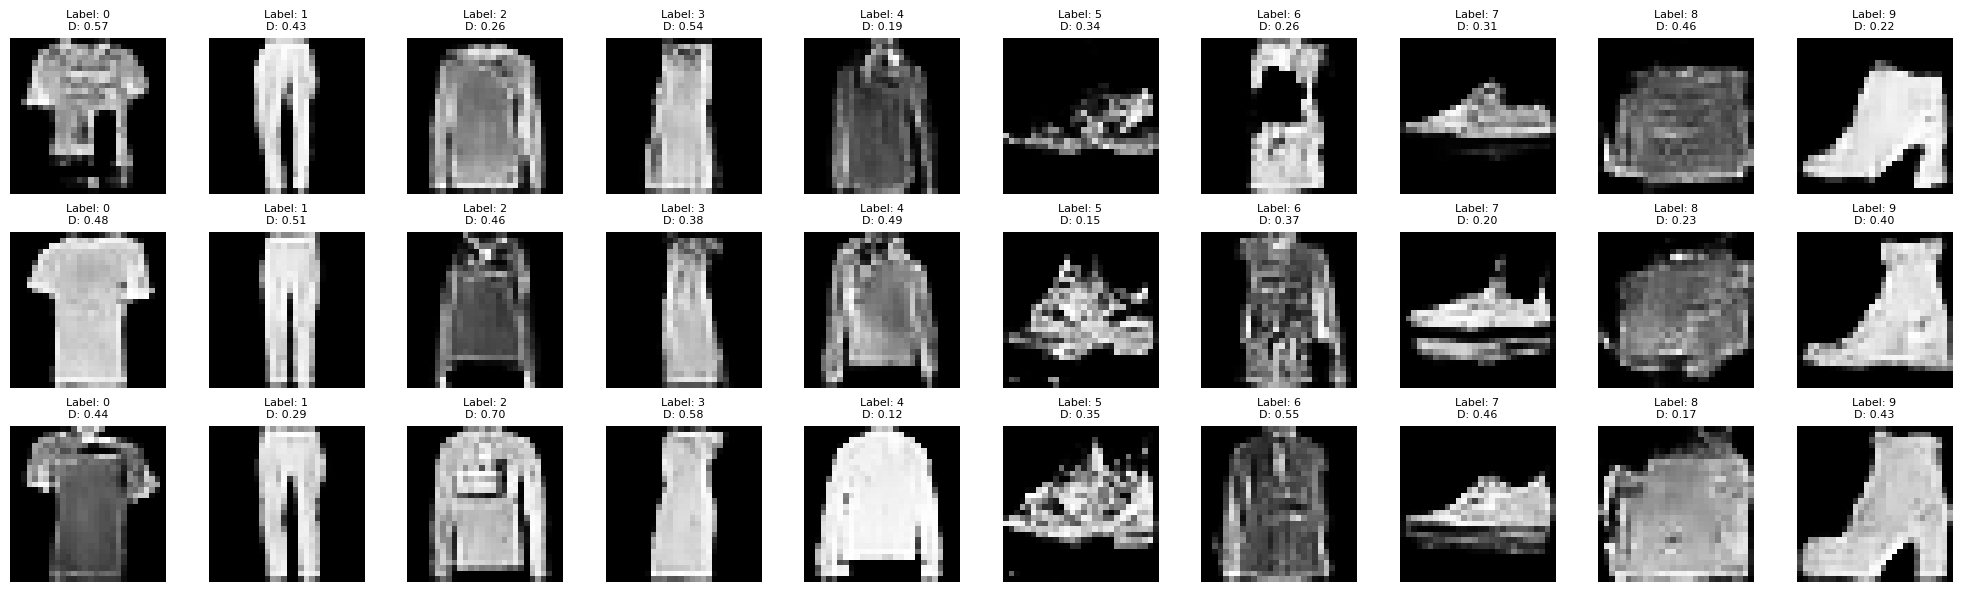

Epoch [11/30]  D_loss: 1.0222  G_loss: 1.2578  D(x): 0.64  D(G(z)): 0.36
Epoch [12/30]  D_loss: 1.0107  G_loss: 1.2865  D(x): 0.64  D(G(z)): 0.36
Epoch [13/30]  D_loss: 1.0103  G_loss: 1.3016  D(x): 0.64  D(G(z)): 0.36
Epoch [14/30]  D_loss: 0.9922  G_loss: 1.3257  D(x): 0.65  D(G(z)): 0.35
Epoch [15/30]  D_loss: 0.9838  G_loss: 1.3438  D(x): 0.65  D(G(z)): 0.35
Epoch [16/30]  D_loss: 0.9763  G_loss: 1.3610  D(x): 0.66  D(G(z)): 0.34
Epoch [17/30]  D_loss: 0.9843  G_loss: 1.3664  D(x): 0.65  D(G(z)): 0.35
Epoch [18/30]  D_loss: 0.9715  G_loss: 1.3832  D(x): 0.66  D(G(z)): 0.34
Epoch [19/30]  D_loss: 0.9613  G_loss: 1.4189  D(x): 0.66  D(G(z)): 0.34
Epoch [20/30]  D_loss: 0.9685  G_loss: 1.4160  D(x): 0.66  D(G(z)): 0.34


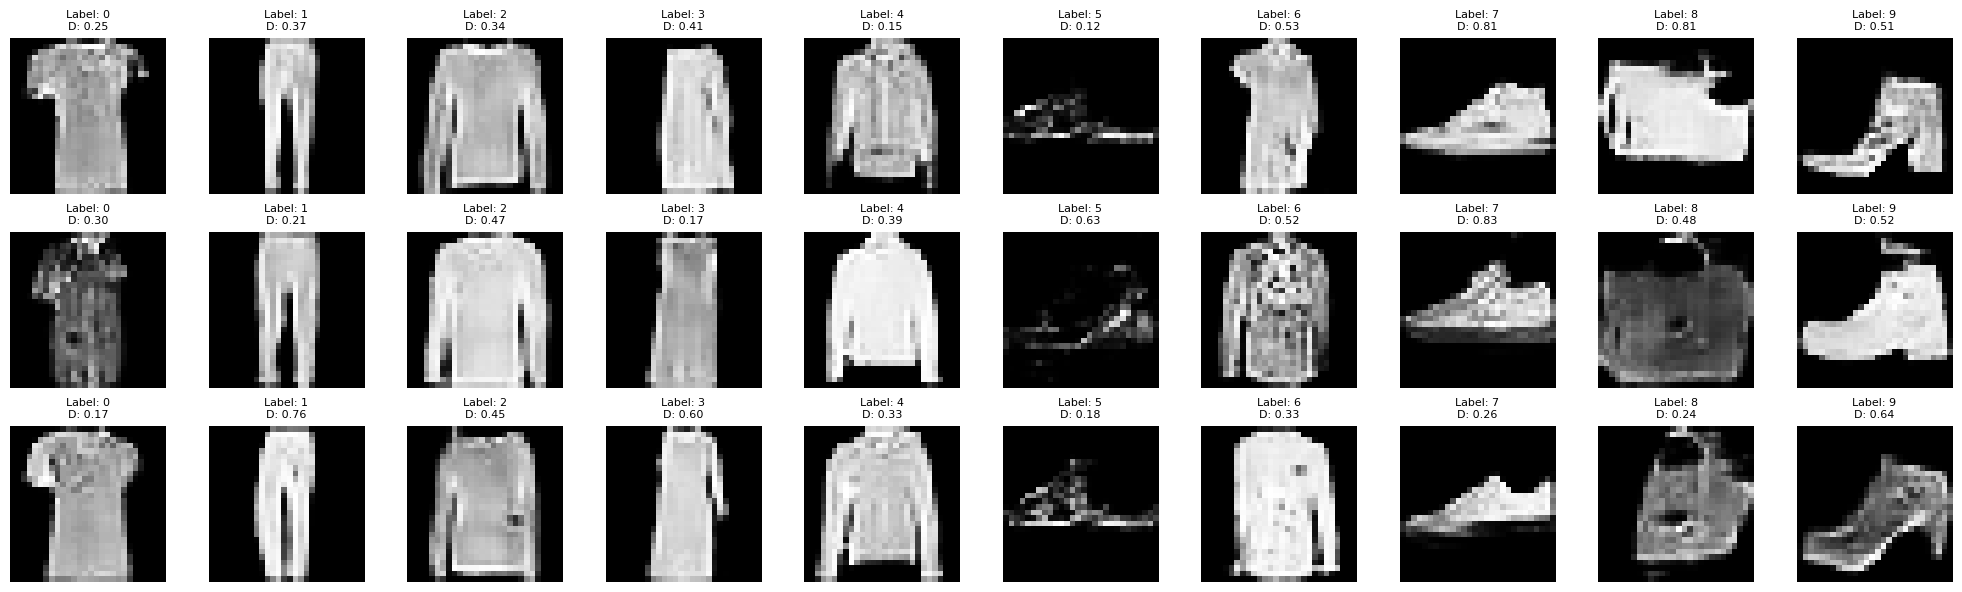

Epoch [21/30]  D_loss: 0.9513  G_loss: 1.4352  D(x): 0.67  D(G(z)): 0.33
Epoch [22/30]  D_loss: 0.9347  G_loss: 1.4680  D(x): 0.67  D(G(z)): 0.33
Epoch [23/30]  D_loss: 0.9238  G_loss: 1.5075  D(x): 0.68  D(G(z)): 0.32
Epoch [24/30]  D_loss: 0.9272  G_loss: 1.5029  D(x): 0.68  D(G(z)): 0.32
Epoch [25/30]  D_loss: 0.9360  G_loss: 1.4889  D(x): 0.67  D(G(z)): 0.33
Epoch [26/30]  D_loss: 0.9253  G_loss: 1.5081  D(x): 0.68  D(G(z)): 0.32
Epoch [27/30]  D_loss: 0.9163  G_loss: 1.5338  D(x): 0.68  D(G(z)): 0.32
Epoch [28/30]  D_loss: 0.9059  G_loss: 1.5691  D(x): 0.68  D(G(z)): 0.32
Epoch [29/30]  D_loss: 0.9023  G_loss: 1.5691  D(x): 0.69  D(G(z)): 0.31
Epoch [30/30]  D_loss: 0.8839  G_loss: 1.5973  D(x): 0.69  D(G(z)): 0.31


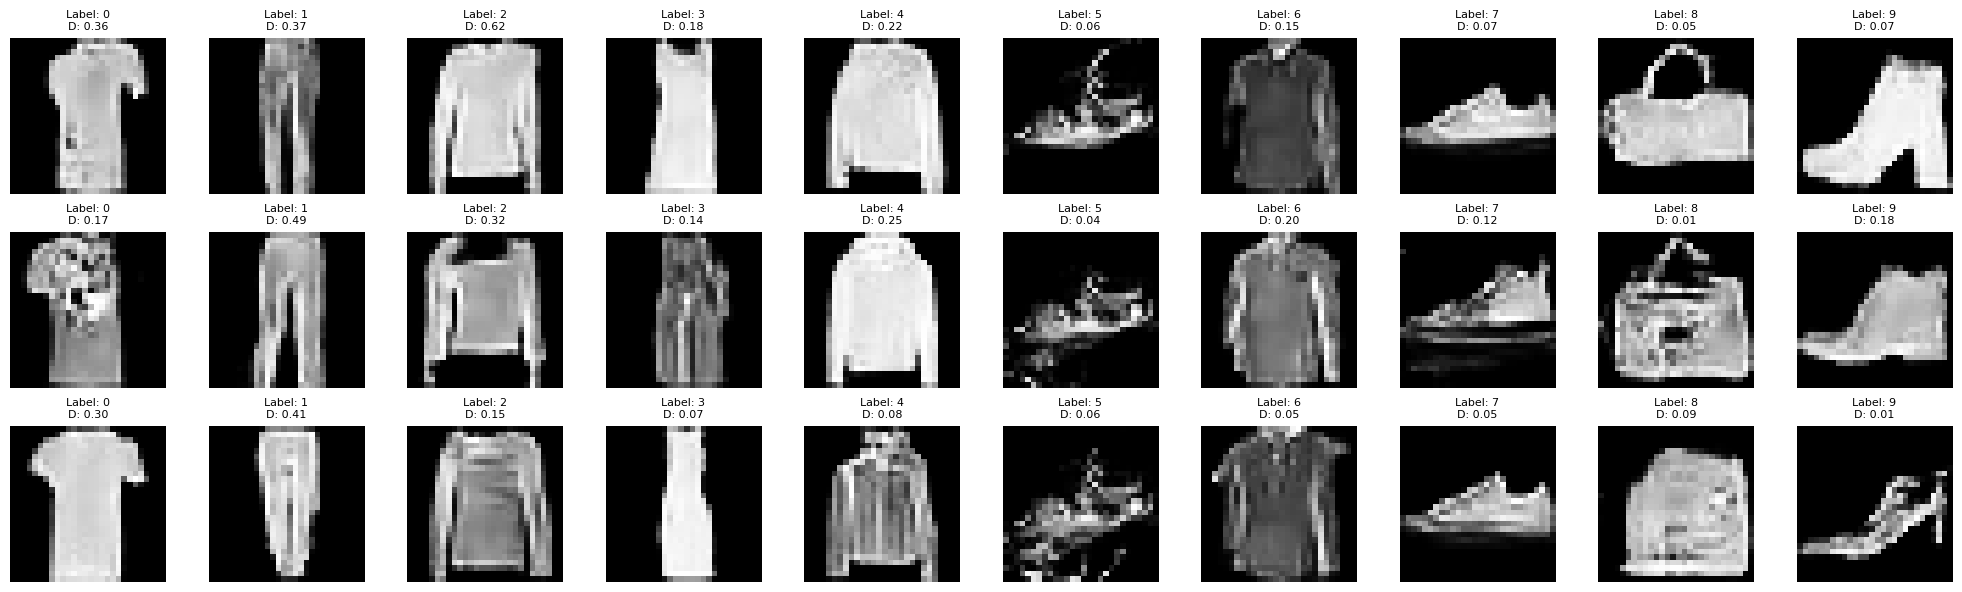

In [6]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

epochs = 30
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 손실값 저장을 위한 리스트
d_losses = []
g_losses = []
d_x_scores = []
d_gz_scores = []

# 학습 루프 (에포크마다 D(x)와 D(G(z)) 평균 점수 계산)
for epoch in range(epochs):
    running_d_loss = 0.0
    running_g_loss = 0.0
    d_x_total = 0.0
    d_gz_total = 0.0
    total_samples = 0

    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)
        total_samples += batch_size_current
        imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size_current, 1, device=device)
        fake  = torch.zeros(batch_size_current, 1, device=device)

        # 판별자 학습
        optimizer_D.zero_grad()
        # 실제 이미지에 대한 판별자 출력
        real_pred = discriminator(imgs, labels)
        real_loss = criterion(real_pred, valid)
        d_x_total += real_pred.mean().item() * batch_size_current

        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_labels = labels  # (여기서는 입력된 라벨 사용)
        gen_imgs = generator(noise, gen_labels)
        # 가짜 이미지에 대한 판별자 출력
        fake_pred = discriminator(gen_imgs.detach(), labels)
        fake_loss = criterion(fake_pred, fake)
        d_gz_total += fake_pred.mean().item() * batch_size_current

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 생성자 학습
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

        running_d_loss += d_loss.item() * batch_size_current
        running_g_loss += g_loss.item() * batch_size_current

    avg_d_loss = running_d_loss / total_samples
    avg_g_loss = running_g_loss / total_samples
    avg_d_x = d_x_total / total_samples
    avg_d_gz = d_gz_total / total_samples

    # 손실값 저장
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    d_x_scores.append(avg_d_x)
    d_gz_scores.append(avg_d_gz)
    
    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {avg_d_loss:.4f}  G_loss: {avg_g_loss:.4f}  D(x): {avg_d_x:.2f}  D(G(z)): {avg_d_gz:.2f}")

    # 10 에포크마다 생성 이미지 시각화 (각 클래스별로 3개씩 출력)
    if (epoch + 1) % 10 == 0:
        generator.eval()
        n_row = 3               # 각 클래스당 3개씩
        n_col = num_classes     # 총 10개 클래스
        total_samples_vis = n_row * n_col
        noise = torch.randn(total_samples_vis, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        with torch.no_grad():
            gen_imgs = generator(noise, labels_sample)
            disc_out = discriminator(gen_imgs, labels_sample)
        gen_imgs = gen_imgs.detach().cpu().numpy()
        disc_out = disc_out.detach().cpu().numpy()

        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col * 2, n_row * 2))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                score = disc_out[idx, 0]
                axs[i, j].set_title(f"Label: {labels_sample[idx].item()}\nD: {score:.2f}", fontsize=8)
        plt.tight_layout()
        plt.show()
        generator.train()

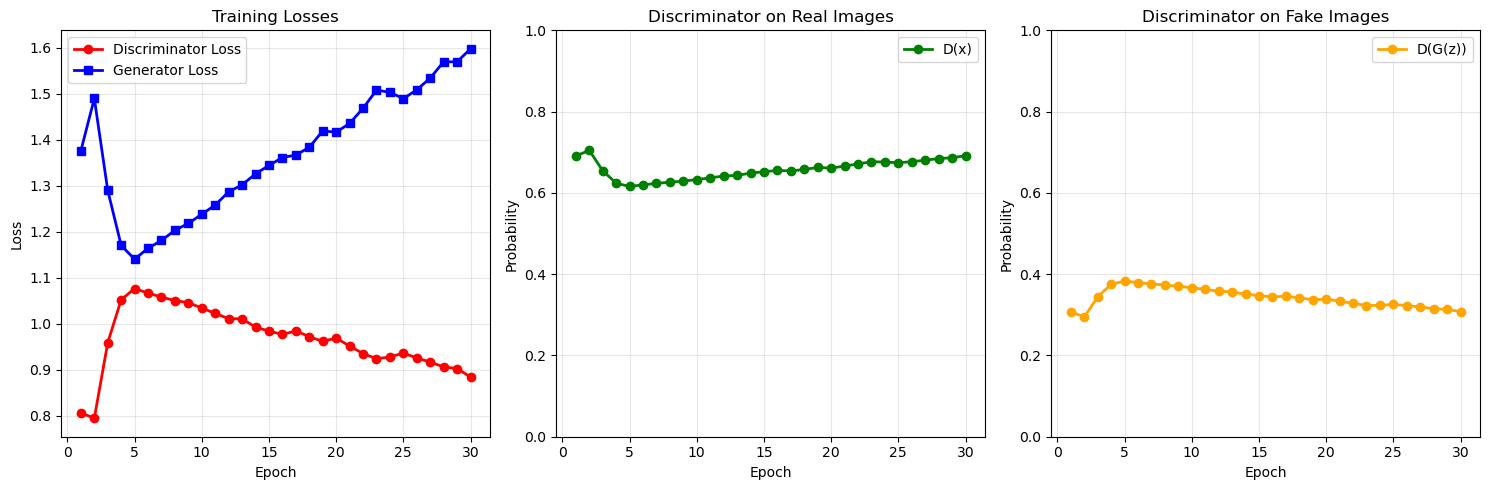


=== 학습 결과 요약 ===
초기 D_loss: 0.8060
최종 D_loss: 0.8839
D_loss 변화: 0.8060 → 0.8839

초기 G_loss: 1.3759
최종 G_loss: 1.5973
G_loss 변화: 1.3759 → 1.5973

초기 D(x): 0.6910
최종 D(x): 0.6917
초기 D(G(z)): 0.3081
최종 D(G(z)): 0.3080

판별자-생성자 균형 (차이: 0.38)
나쁨


In [7]:
# 학습 완료 후 손실 그래프 그리기
plt.figure(figsize=(15, 5))

# 1. 손실값 그래프
plt.subplot(1, 3, 1)
epochs_list = list(range(1, len(d_losses) + 1))
plt.plot(epochs_list, d_losses, 'r-', label='Discriminator Loss', linewidth=2, marker='o')
plt.plot(epochs_list, g_losses, 'b-', label='Generator Loss', linewidth=2, marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. D(x) 그래프 (진짜 이미지에 대한 판별자 확률)
plt.subplot(1, 3, 2)
plt.plot(epochs_list, d_x_scores, 'g-', label='D(x)', linewidth=2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.title('Discriminator on Real Images')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# 3. D(G(z)) 그래프 (가짜 이미지에 대한 판별자 확률)
plt.subplot(1, 3, 3)
plt.plot(epochs_list, d_gz_scores, 'orange', label='D(G(z))', linewidth=2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.title('Discriminator on Fake Images')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# 손실값 요약 통계
print("\n=== 학습 결과 요약 ===")
print(f"초기 D_loss: {d_losses[0]:.4f}")
print(f"최종 D_loss: {d_losses[-1]:.4f}")
print(f"D_loss 변화: {d_losses[0]:.4f} → {d_losses[-1]:.4f}")

print(f"\n초기 G_loss: {g_losses[0]:.4f}")
print(f"최종 G_loss: {g_losses[-1]:.4f}")
print(f"G_loss 변화: {g_losses[0]:.4f} → {g_losses[-1]:.4f}")

print(f"\n초기 D(x): {d_x_scores[0]:.4f}")
print(f"최종 D(x): {d_x_scores[-1]:.4f}")
print(f"초기 D(G(z)): {d_gz_scores[0]:.4f}")
print(f"최종 D(G(z)): {d_gz_scores[-1]:.4f}")

# GAN 균형 상태 평가
d_gap = abs(d_x_scores[-1] - d_gz_scores[-1])
print(f"\n판별자-생성자 균형 (차이: {d_gap:.2f})")
if d_gap < 0.05:
    print("아주 좋음 (Nash Equilibrium)")
elif d_gap < 0.1:
    print("좋음")
elif d_gap < 0.2:
    print("보통")
else:
    print("나쁨")

생성된 이미지의 shape: torch.Size([8, 1, 28, 28])
판별자 출력의 shape: torch.Size([8, 1])


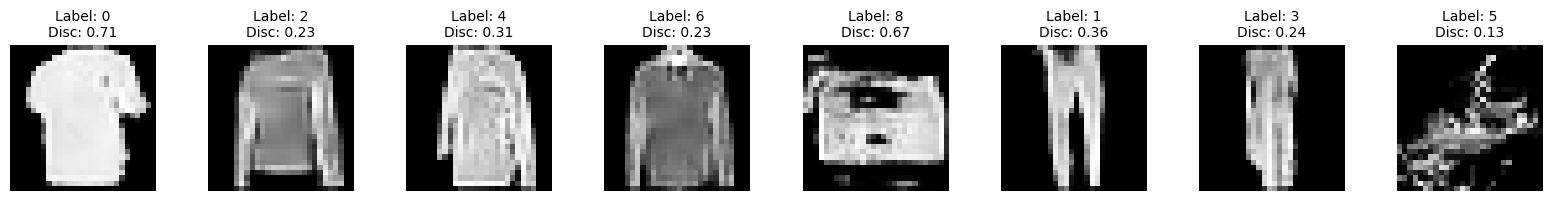

In [8]:
# generator와 discriminator 작동 확인 및 시각화 (라벨, 판별자 결과 포함)
generator.eval()
discriminator.eval()

manual_labels = torch.tensor([0, 2, 4, 6, 8, 1, 3, 5], device=device)
batch_size = manual_labels.size(0)

# 입력 라벨에 맞춰 노이즈 생성
noise = torch.randn(batch_size, latent_dim, device=device)

# 생성자와 판별자 실행
with torch.no_grad():
    fake_images = generator(noise, manual_labels)
    disc_output = discriminator(fake_images, manual_labels)

print("생성된 이미지의 shape:", fake_images.shape)  # [batch_size, 1, 28, 28]
print("판별자 출력의 shape:", disc_output.shape)     # [batch_size, 1]

# 결과 시각화: 생성된 이미지와 라벨, 판별자 결과를 함께 표시
import matplotlib.pyplot as plt

fake_images_cpu = fake_images.detach().cpu().numpy()
disc_output_cpu = disc_output.detach().cpu().numpy()

fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 2, 2))
for i in range(batch_size):
    axs[i].imshow(fake_images_cpu[i, 0, :, :], cmap='gray')
    axs[i].axis('off')
    score = disc_output_cpu[i, 0]
    axs[i].set_title(f"Label: {manual_labels[i].item()}\nDisc: {score:.2f}", fontsize=10)
plt.tight_layout()
plt.show()


____

생성자 네트워크 깊이를 1단계 더 늘리고, 판별자보다 2배로 학습을 늘려보기

- 생성자 네트워크 깊이 증가
   - 목적 : 더 복잡한 패턴 학습 능력 향상
   - 기대 효과 : 더 정교하고 품질 높은 이미지 생성
   - 위험 : 학습 불안정성 증가 가능

- 생성자 2배 더 학습
   - 목적 : 생성자-판별자 균형 조정
   - 현재 문제 : D(G(z)) = 0.38로 생성자가 약함
   - 기대 효과 : D(G(z))를 0.5에 가깝게 만들어 균형 개선

In [9]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 레이블 임베딩
        self.label_emb = nn.Embedding(num_classes, num_classes) #--> 10 * 10 like one-hot

        self.init_size = image_size // 4  # 7

        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 → 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 14 → 28

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(32, momentum=0.8),                       
            nn.ReLU(inplace=True),                                  
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),   
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

Epoch [1/50]  D_loss: 1.3215  G_loss: 0.7773  D(x): 0.52  D(G(z)): 0.48
Epoch [2/50]  D_loss: 1.3903  G_loss: 0.7239  D(x): 0.50  D(G(z)): 0.50
Epoch [3/50]  D_loss: 1.3993  G_loss: 0.7082  D(x): 0.50  D(G(z)): 0.50
Epoch [4/50]  D_loss: 1.3994  G_loss: 0.7037  D(x): 0.50  D(G(z)): 0.50
Epoch [5/50]  D_loss: 1.3992  G_loss: 0.7024  D(x): 0.50  D(G(z)): 0.50
Epoch [6/50]  D_loss: 1.3969  G_loss: 0.7011  D(x): 0.50  D(G(z)): 0.50
Epoch [7/50]  D_loss: 1.3953  G_loss: 0.7015  D(x): 0.50  D(G(z)): 0.50
Epoch [8/50]  D_loss: 1.3955  G_loss: 0.6993  D(x): 0.50  D(G(z)): 0.50
Epoch [9/50]  D_loss: 1.3935  G_loss: 0.7000  D(x): 0.50  D(G(z)): 0.50
Epoch [10/50]  D_loss: 1.3933  G_loss: 0.6997  D(x): 0.50  D(G(z)): 0.50


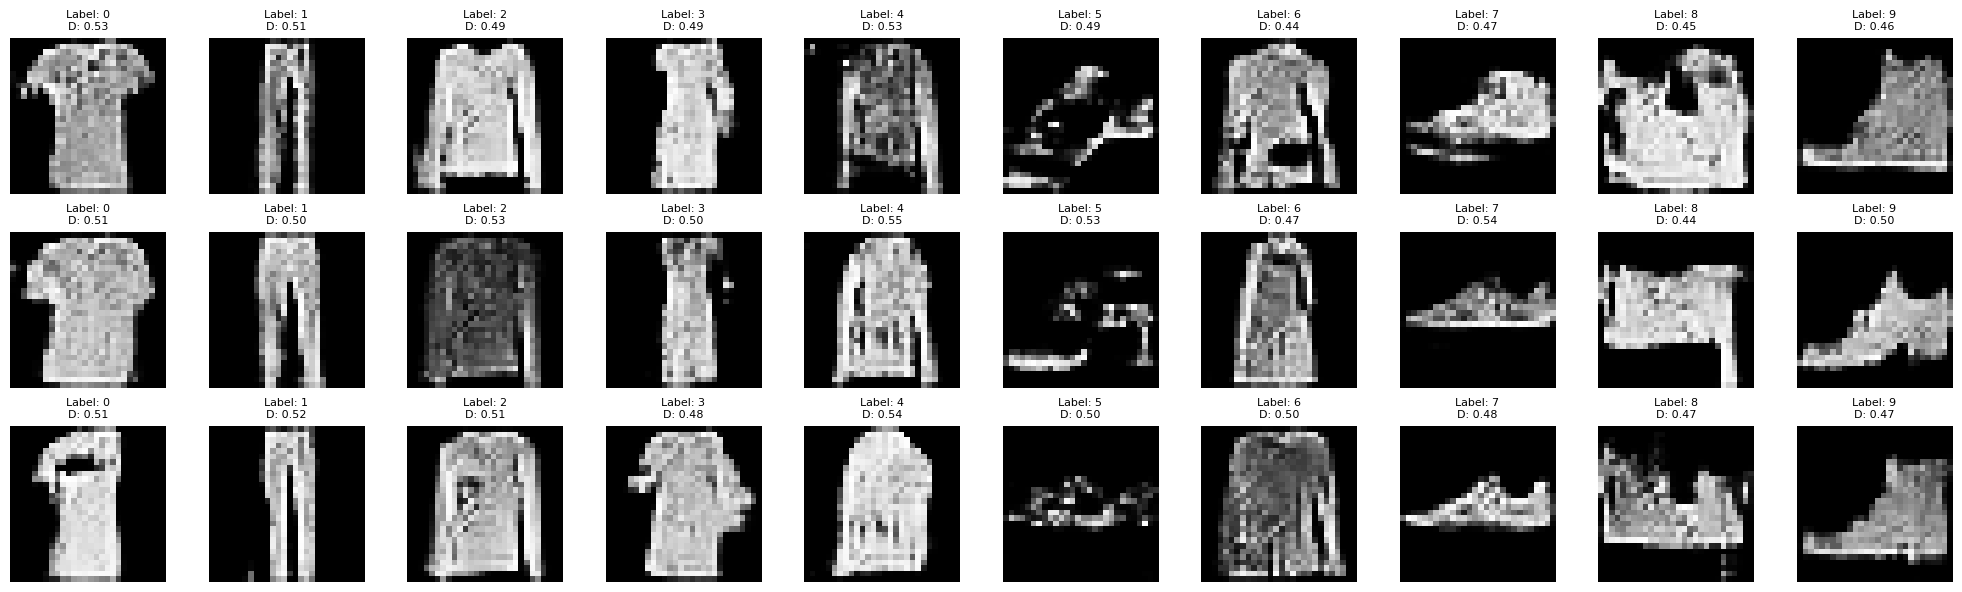

Epoch [11/50]  D_loss: 1.3919  G_loss: 0.7008  D(x): 0.50  D(G(z)): 0.50
Epoch [12/50]  D_loss: 1.3914  G_loss: 0.7000  D(x): 0.50  D(G(z)): 0.50
Epoch [13/50]  D_loss: 1.3908  G_loss: 0.7001  D(x): 0.50  D(G(z)): 0.50
Epoch [14/50]  D_loss: 1.3900  G_loss: 0.7024  D(x): 0.50  D(G(z)): 0.50
Epoch [15/50]  D_loss: 1.3899  G_loss: 0.7016  D(x): 0.50  D(G(z)): 0.50
Epoch [16/50]  D_loss: 1.3897  G_loss: 0.7024  D(x): 0.50  D(G(z)): 0.50
Epoch [17/50]  D_loss: 1.3885  G_loss: 0.7038  D(x): 0.50  D(G(z)): 0.50
Epoch [18/50]  D_loss: 1.3890  G_loss: 0.7029  D(x): 0.50  D(G(z)): 0.50
Epoch [19/50]  D_loss: 1.3892  G_loss: 0.7043  D(x): 0.50  D(G(z)): 0.50
Epoch [20/50]  D_loss: 1.3867  G_loss: 0.7060  D(x): 0.50  D(G(z)): 0.50


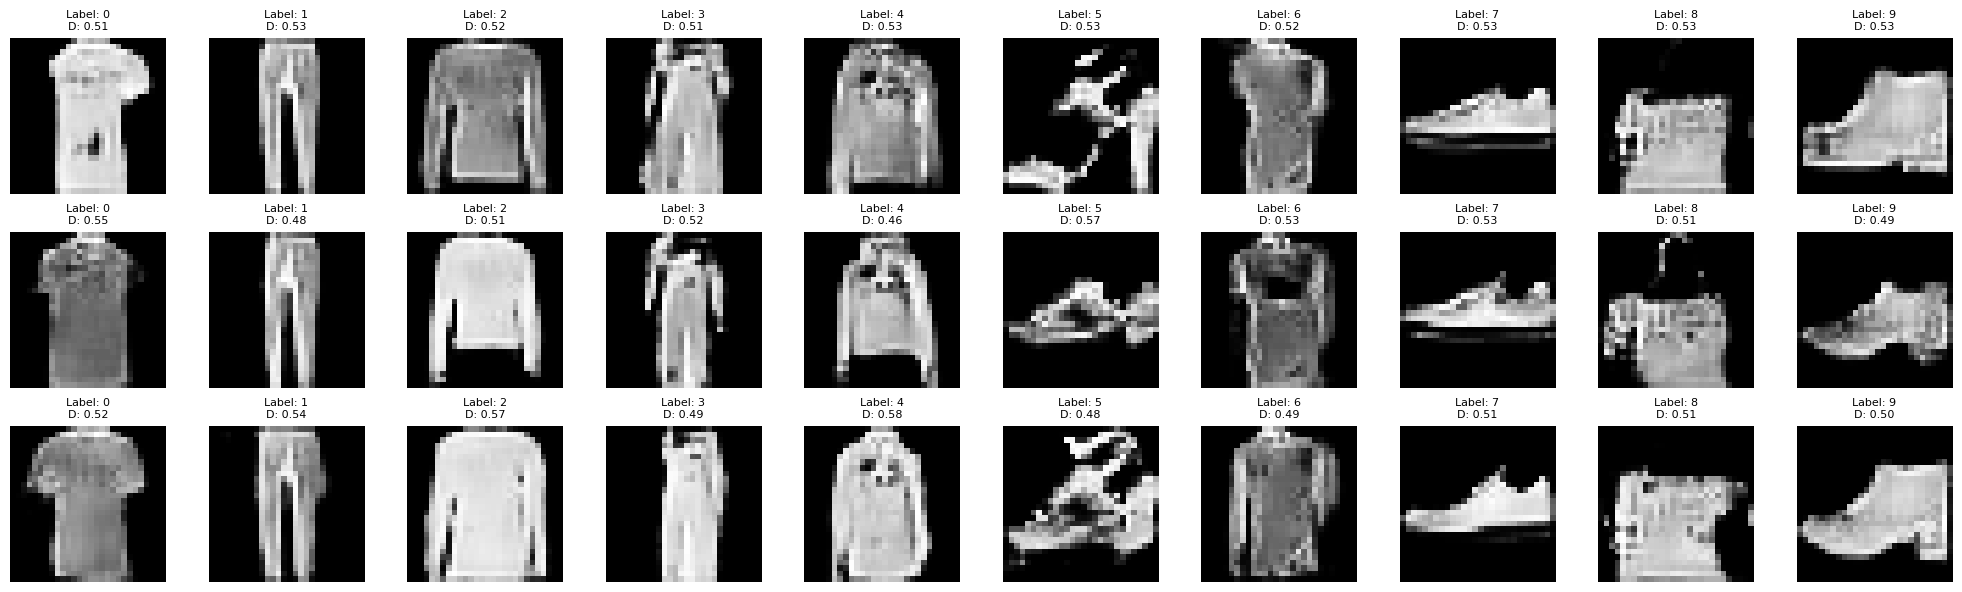

Epoch [21/50]  D_loss: 1.3847  G_loss: 0.7090  D(x): 0.50  D(G(z)): 0.50
Epoch [22/50]  D_loss: 1.3848  G_loss: 0.7089  D(x): 0.50  D(G(z)): 0.50
Epoch [23/50]  D_loss: 1.3821  G_loss: 0.7126  D(x): 0.50  D(G(z)): 0.50
Epoch [24/50]  D_loss: 1.3801  G_loss: 0.7158  D(x): 0.50  D(G(z)): 0.50
Epoch [25/50]  D_loss: 1.3781  G_loss: 0.7179  D(x): 0.50  D(G(z)): 0.49
Epoch [26/50]  D_loss: 1.3775  G_loss: 0.7216  D(x): 0.51  D(G(z)): 0.49
Epoch [27/50]  D_loss: 1.3720  G_loss: 0.7252  D(x): 0.51  D(G(z)): 0.49
Epoch [28/50]  D_loss: 1.3701  G_loss: 0.7317  D(x): 0.51  D(G(z)): 0.49
Epoch [29/50]  D_loss: 1.3662  G_loss: 0.7362  D(x): 0.51  D(G(z)): 0.49
Epoch [30/50]  D_loss: 1.3597  G_loss: 0.7422  D(x): 0.51  D(G(z)): 0.49


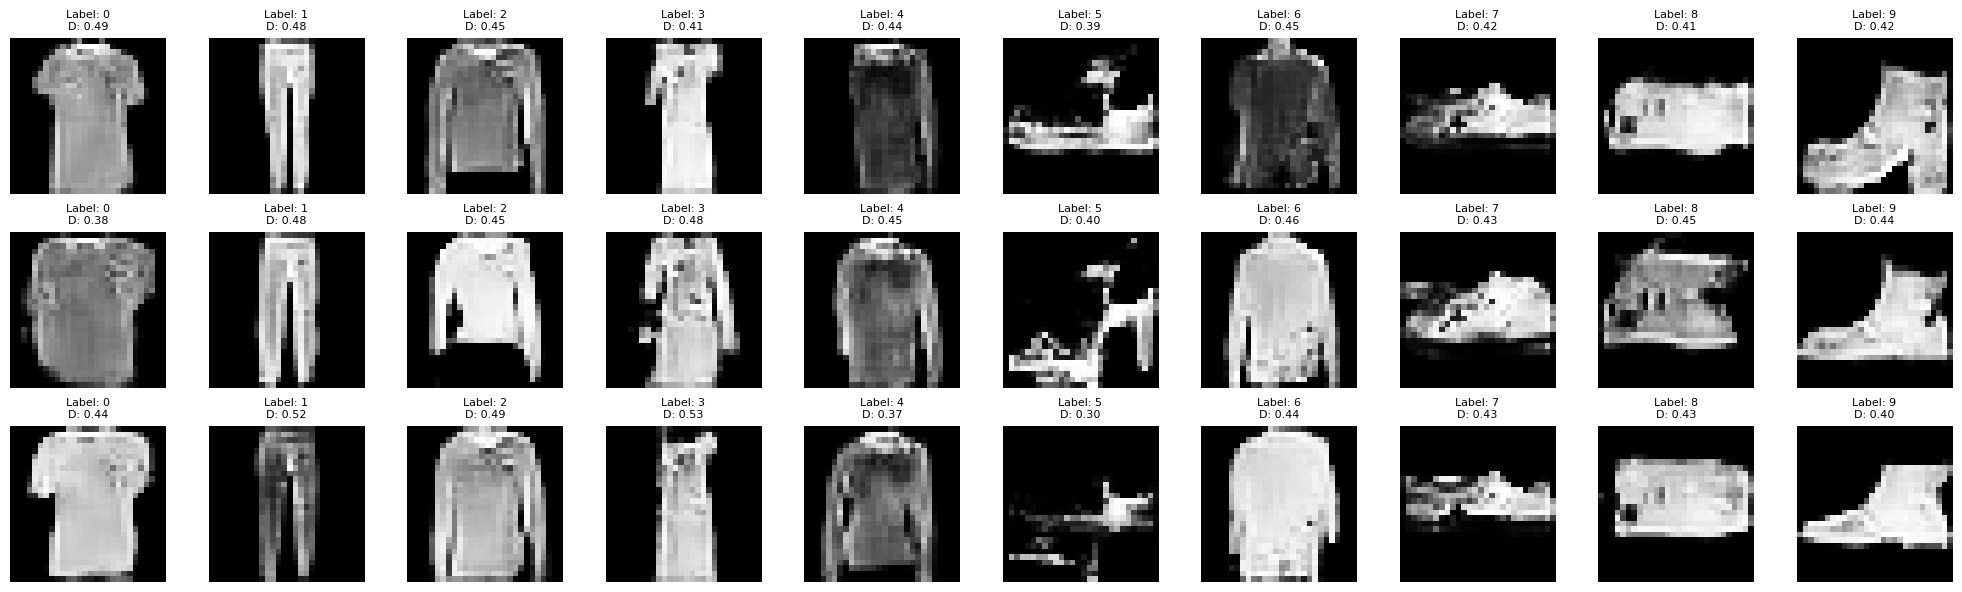

Epoch [31/50]  D_loss: 1.3556  G_loss: 0.7482  D(x): 0.51  D(G(z)): 0.49
Epoch [32/50]  D_loss: 1.3529  G_loss: 0.7508  D(x): 0.52  D(G(z)): 0.48
Epoch [33/50]  D_loss: 1.3499  G_loss: 0.7562  D(x): 0.52  D(G(z)): 0.48
Epoch [34/50]  D_loss: 1.3481  G_loss: 0.7616  D(x): 0.52  D(G(z)): 0.48
Epoch [35/50]  D_loss: 1.3419  G_loss: 0.7669  D(x): 0.52  D(G(z)): 0.48
Epoch [36/50]  D_loss: 1.3362  G_loss: 0.7737  D(x): 0.52  D(G(z)): 0.48
Epoch [37/50]  D_loss: 1.3302  G_loss: 0.7805  D(x): 0.52  D(G(z)): 0.48
Epoch [38/50]  D_loss: 1.3258  G_loss: 0.7912  D(x): 0.53  D(G(z)): 0.47
Epoch [39/50]  D_loss: 1.3152  G_loss: 0.8004  D(x): 0.53  D(G(z)): 0.47
Epoch [40/50]  D_loss: 1.3013  G_loss: 0.8137  D(x): 0.53  D(G(z)): 0.46


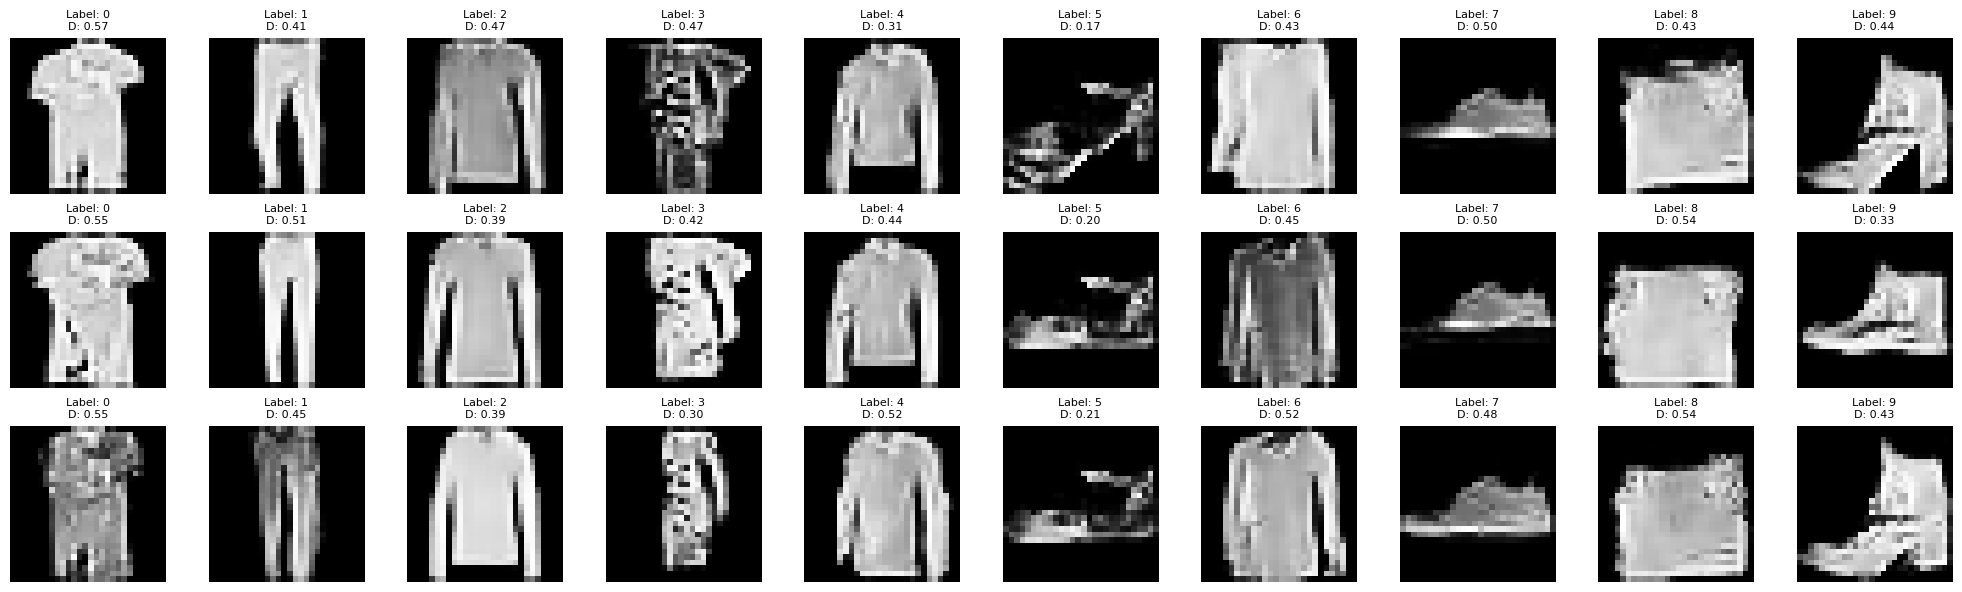

Epoch [41/50]  D_loss: 1.2949  G_loss: 0.8270  D(x): 0.54  D(G(z)): 0.46
Epoch [42/50]  D_loss: 1.2879  G_loss: 0.8304  D(x): 0.54  D(G(z)): 0.46
Epoch [43/50]  D_loss: 1.2818  G_loss: 0.8421  D(x): 0.54  D(G(z)): 0.46
Epoch [44/50]  D_loss: 1.2701  G_loss: 0.8588  D(x): 0.55  D(G(z)): 0.45
Epoch [45/50]  D_loss: 1.2657  G_loss: 0.8669  D(x): 0.55  D(G(z)): 0.45
Epoch [46/50]  D_loss: 1.2439  G_loss: 0.8903  D(x): 0.56  D(G(z)): 0.44
Epoch [47/50]  D_loss: 1.2588  G_loss: 0.8819  D(x): 0.55  D(G(z)): 0.45
Epoch [48/50]  D_loss: 1.2128  G_loss: 0.9216  D(x): 0.57  D(G(z)): 0.43
Epoch [49/50]  D_loss: 1.1733  G_loss: 0.9587  D(x): 0.58  D(G(z)): 0.42
Epoch [50/50]  D_loss: 1.1528  G_loss: 0.9943  D(x): 0.59  D(G(z)): 0.41


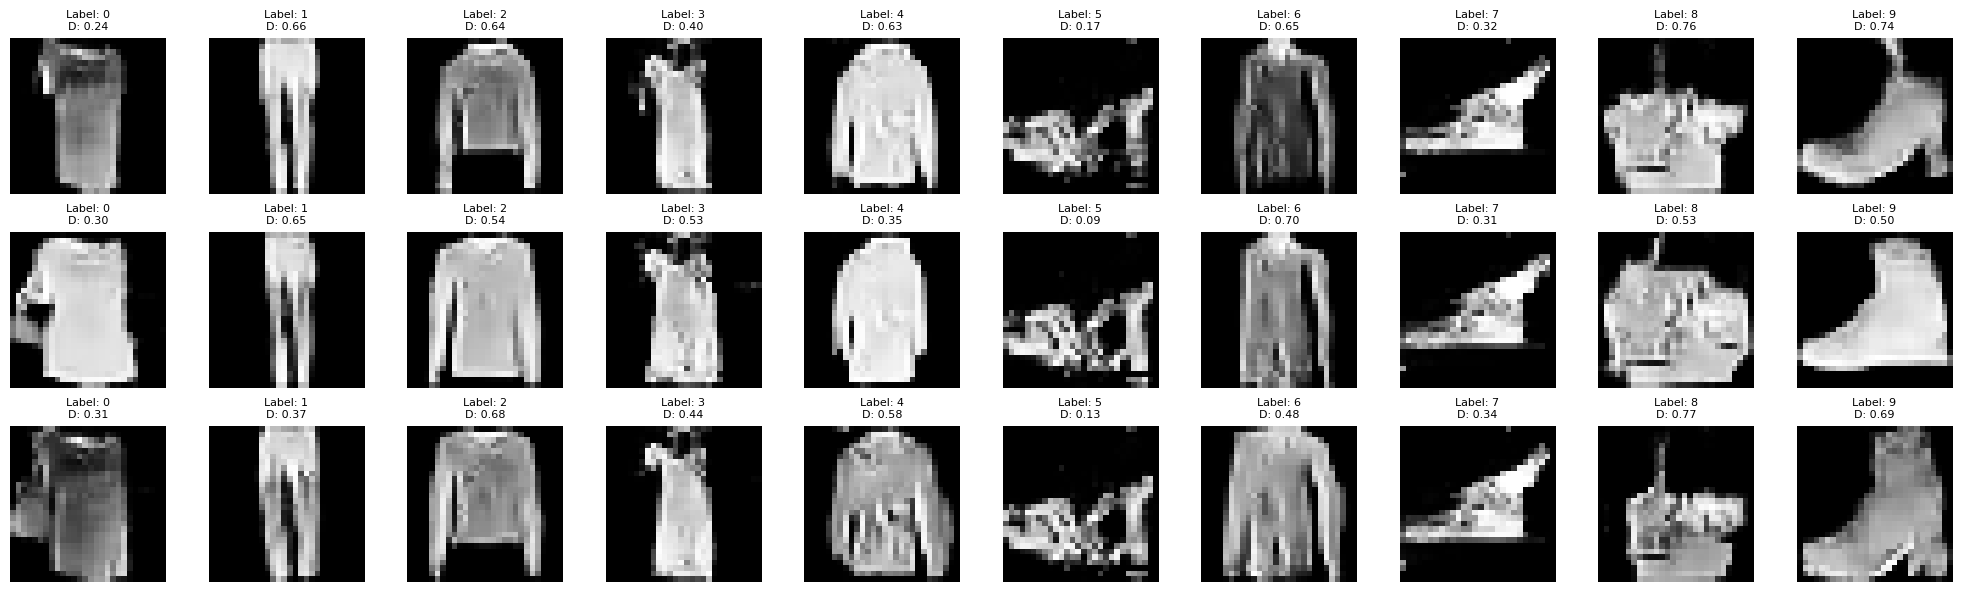

In [10]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

epochs = 50
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 손실값 저장을 위한 리스트
d_losses = []
g_losses = []
d_x_scores = []
d_gz_scores = []

# 학습 루프 (에포크마다 D(x)와 D(G(z)) 평균 점수 계산)
for epoch in range(epochs):
    running_d_loss = 0.0
    running_g_loss = 0.0
    d_x_total = 0.0
    d_gz_total = 0.0
    total_samples = 0

    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)
        total_samples += batch_size_current
        imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size_current, 1, device=device)
        fake  = torch.zeros(batch_size_current, 1, device=device)

        # 판별자 학습
        optimizer_D.zero_grad()
        # 실제 이미지에 대한 판별자 출력
        real_pred = discriminator(imgs, labels)
        real_loss = criterion(real_pred, valid)
        d_x_total += real_pred.mean().item() * batch_size_current

        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_labels = labels  # (여기서는 입력된 라벨 사용)
        gen_imgs = generator(noise, gen_labels)
        # 가짜 이미지에 대한 판별자 출력
        fake_pred = discriminator(gen_imgs.detach(), labels)
        fake_loss = criterion(fake_pred, fake)
        d_gz_total += fake_pred.mean().item() * batch_size_current

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 생성자 학습
        for j in range(2):  # 생성자 2번 학습
            optimizer_G.zero_grad()
            # 매번 새로운 가짜 이미지 생성
            noise = torch.randn(batch_size_current, latent_dim, device=device)
            gen_imgs = generator(noise, labels)  # 새로운 이미지 생성
            g_loss = criterion(discriminator(gen_imgs, labels), valid)
            g_loss.backward()
            optimizer_G.step()

        running_d_loss += d_loss.item() * batch_size_current
        running_g_loss += g_loss.item() * batch_size_current

    avg_d_loss = running_d_loss / total_samples
    avg_g_loss = running_g_loss / total_samples
    avg_d_x = d_x_total / total_samples
    avg_d_gz = d_gz_total / total_samples

    # 손실값 저장
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)
    d_x_scores.append(avg_d_x)
    d_gz_scores.append(avg_d_gz)
    
    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {avg_d_loss:.4f}  G_loss: {avg_g_loss:.4f}  D(x): {avg_d_x:.2f}  D(G(z)): {avg_d_gz:.2f}")

    # 10 에포크마다 생성 이미지 시각화 (각 클래스별로 3개씩 출력)
    if (epoch + 1) % 10 == 0:
        generator.eval()
        n_row = 3               # 각 클래스당 3개씩
        n_col = num_classes     # 총 10개 클래스
        total_samples_vis = n_row * n_col
        noise = torch.randn(total_samples_vis, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        with torch.no_grad():
            gen_imgs = generator(noise, labels_sample)
            disc_out = discriminator(gen_imgs, labels_sample)
        gen_imgs = gen_imgs.detach().cpu().numpy()
        disc_out = disc_out.detach().cpu().numpy()

        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col * 2, n_row * 2))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                score = disc_out[idx, 0]
                axs[i, j].set_title(f"Label: {labels_sample[idx].item()}\nD: {score:.2f}", fontsize=8)
        plt.tight_layout()
        plt.show()
        generator.train()

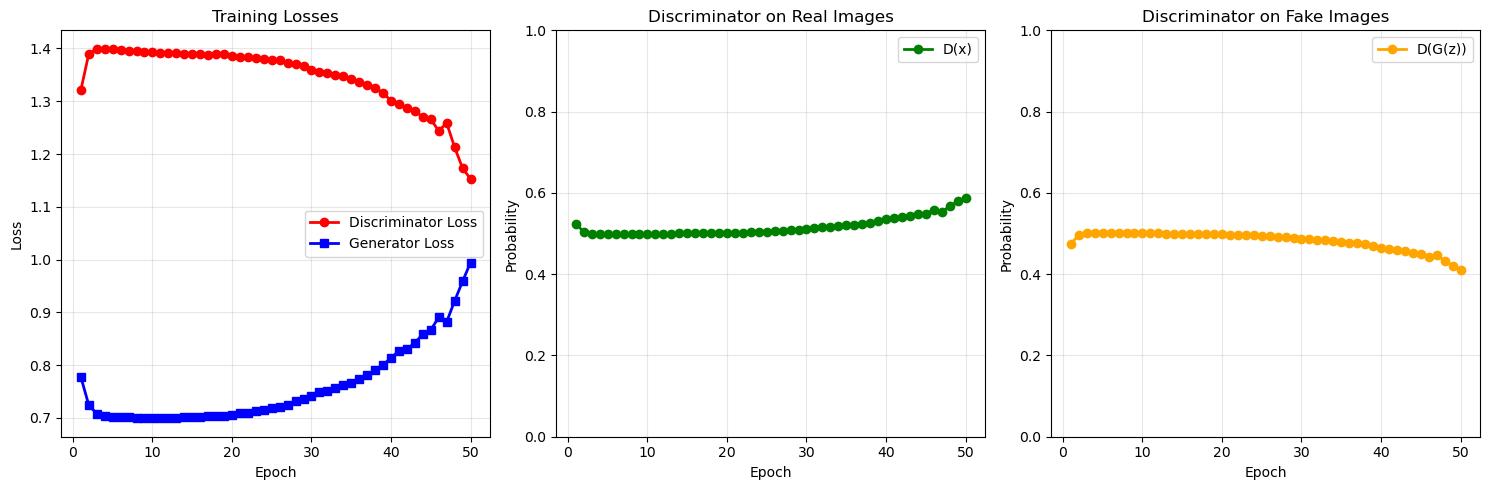


=== 학습 결과 요약 ===
초기 D_loss: 1.3215
최종 D_loss: 1.1528
D_loss 변화: 1.3215 → 1.1528

초기 G_loss: 0.7773
최종 G_loss: 0.9943
G_loss 변화: 0.7773 → 0.9943

초기 D(x): 0.5244
최종 D(x): 0.5880
초기 D(G(z)): 0.4752
최종 D(G(z)): 0.4115

판별자-생성자 균형 (차이: 0.18)
보통


In [11]:
# 학습 완료 후 손실 그래프 그리기
plt.figure(figsize=(15, 5))

# 1. 손실값 그래프
plt.subplot(1, 3, 1)
epochs_list = list(range(1, len(d_losses) + 1))
plt.plot(epochs_list, d_losses, 'r-', label='Discriminator Loss', linewidth=2, marker='o')
plt.plot(epochs_list, g_losses, 'b-', label='Generator Loss', linewidth=2, marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. D(x) 그래프 (진짜 이미지에 대한 판별자 확률)
plt.subplot(1, 3, 2)
plt.plot(epochs_list, d_x_scores, 'g-', label='D(x)', linewidth=2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.title('Discriminator on Real Images')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# 3. D(G(z)) 그래프 (가짜 이미지에 대한 판별자 확률)
plt.subplot(1, 3, 3)
plt.plot(epochs_list, d_gz_scores, 'orange', label='D(G(z))', linewidth=2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.title('Discriminator on Fake Images')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# 손실값 요약 통계
print("\n=== 학습 결과 요약 ===")
print(f"초기 D_loss: {d_losses[0]:.4f}")
print(f"최종 D_loss: {d_losses[-1]:.4f}")
print(f"D_loss 변화: {d_losses[0]:.4f} → {d_losses[-1]:.4f}")

print(f"\n초기 G_loss: {g_losses[0]:.4f}")
print(f"최종 G_loss: {g_losses[-1]:.4f}")
print(f"G_loss 변화: {g_losses[0]:.4f} → {g_losses[-1]:.4f}")

print(f"\n초기 D(x): {d_x_scores[0]:.4f}")
print(f"최종 D(x): {d_x_scores[-1]:.4f}")
print(f"초기 D(G(z)): {d_gz_scores[0]:.4f}")
print(f"최종 D(G(z)): {d_gz_scores[-1]:.4f}")

# GAN 균형 상태 평가
d_gap = abs(d_x_scores[-1] - d_gz_scores[-1])
print(f"\n판별자-생성자 균형 (차이: {d_gap:.2f})")
if d_gap < 0.05:
    print("아주 좋음 (Nash Equilibrium)")
elif d_gap < 0.1:
    print("좋음")
elif d_gap < 0.2:
    print("보통")
else:
    print("나쁨")

생성된 이미지의 shape: torch.Size([8, 1, 28, 28])
판별자 출력의 shape: torch.Size([8, 1])


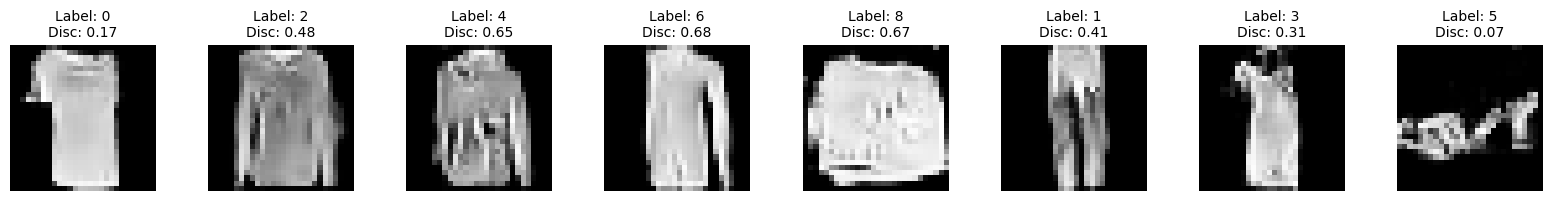

In [12]:
# generator와 discriminator 작동 확인 및 시각화 (라벨, 판별자 결과 포함)
generator.eval()
discriminator.eval()

manual_labels = torch.tensor([0, 2, 4, 6, 8, 1, 3, 5], device=device)
batch_size = manual_labels.size(0)

# 입력 라벨에 맞춰 노이즈 생성
noise = torch.randn(batch_size, latent_dim, device=device)

# 생성자와 판별자 실행
with torch.no_grad():
    fake_images = generator(noise, manual_labels)
    disc_output = discriminator(fake_images, manual_labels)

print("생성된 이미지의 shape:", fake_images.shape)  # [batch_size, 1, 28, 28]
print("판별자 출력의 shape:", disc_output.shape)     # [batch_size, 1]

# 결과 시각화: 생성된 이미지와 라벨, 판별자 결과를 함께 표시
import matplotlib.pyplot as plt

fake_images_cpu = fake_images.detach().cpu().numpy()
disc_output_cpu = disc_output.detach().cpu().numpy()

fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 2, 2))
for i in range(batch_size):
    axs[i].imshow(fake_images_cpu[i, 0, :, :], cmap='gray')
    axs[i].axis('off')
    score = disc_output_cpu[i, 0]
    axs[i].set_title(f"Label: {manual_labels[i].item()}\nDisc: {score:.2f}", fontsize=10)
plt.tight_layout()
plt.show()


# 결론 및 학습 성과 분석

본 프로젝트에서는 조건부 생성적 적대 신경망(Conditional GAN)을 활용하여 Fashion MNIST 데이터셋의 10개 클래스별 이미지 생성 모델을 구현하고 학습을 진행했습니다. 초기 학습에서는 생성자와 판별자 간의 균형 문제와 네트워크 구조의 한계로 인해 생성 품질이 기대에 미치지 못하는 문제가 발생했습니다.

## 문제 해결 전략 및 결과
- 이러한 문제를 해결하고 생성 모델의 성능을 극대화하기 위해 다음과 같은 전략을 적용했습니다:

1. 생성자 네트워크 심화

- 생성자의 표현력을 강화하기 위해 기존 2단계였던 전치 합성곱(Transposed Convolution) 계층을 3단계로 확장했습니다. 128 → 64 → 32 → 1 채널 구조로 변경하여 더욱 복잡하고 정교한 이미지 특징을 학습할 수 있도록 네트워크 깊이를 늘렸습니다.

2. 생성자 학습 빈도 증가

- 판별자가 1회 학습할 때, 생성자가 2회 학습하도록 생성자의 학습 빈도를 증가시켰습니다. 이를 통해 판별자의 강력한 구별 능력을 생성자가 효과적으로 따라잡고 균형을 맞출 수 있도록 훈련 시간을 확보했습니다.

## 학습 성과 분석
손실 그래프 분석 요약

균형 있는 경쟁 구도 형성

- 후반부 학습(35-50 에포크)에서는 D(x) = 0.59, D(G(z)) = 0.41로 발전하여 차이 0.18의 건강한 경쟁 구도를 형성했습니다. 이는 판별자가 진짜 이미지를 더 잘 인식하면서도, 생성자가 지속적으로 도전적인 이미지를 생성하는 균형 잡힌 상태를 나타냅니다.

GAN 발전 과정

- 초기 (1-25 에포크): 완벽한 Nash Equilibrium
- 중기 (25-35 에포크): 판별자 성능 향상
- 후기 (35-50 에포크): 생성자 도전 증가